# WORKFLOW for the creation of the ML potentials at Constant Potential

Requirements:

- "Franken" => training and testing of the ML potential
- "LAMMPS" => MD
- "DEAL" python suite + "FLARE" => selection of new configurations
- "VASP" (or alternatively a DFT code) => single-point calculations for the labelling of the configurations 
- "DoubleRefernceMethod" python suite => handling of the DFT workflow

Sequence of STEPS:

0. **STEP 0**: Development of a PZC model (alternatively a pre-trained general-purpose model can be employed) => see notebook "Workflow_PZC.ipynb" 
1. **STEP 1**: Training via Transfer Learning
2. **STEP 2**: Explorative MD simulation with LAMMPS
3. **STEP 3**: "DEAL" selection of new configurations
4. **STEP 4**: Single-point calculations for the labelling of the configurations at constant potential

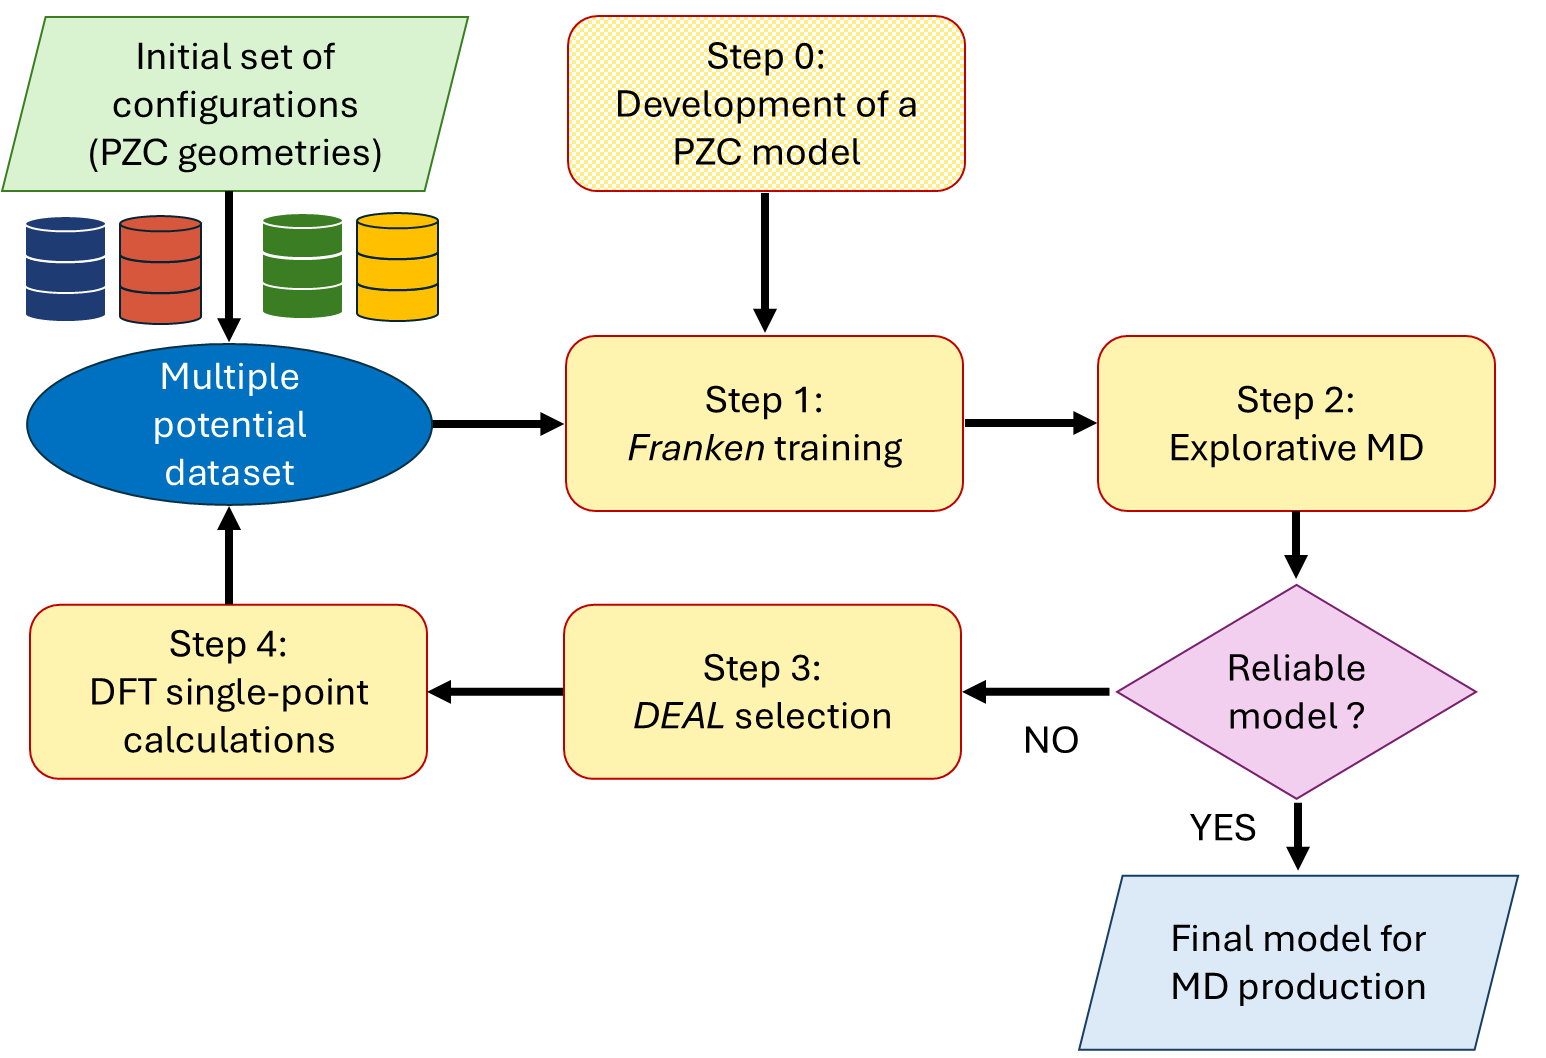

In [1]:
from IPython.display import Image
Image(filename='CP_workflow_general.png',width=700, height=600)

These steps should be repeated until the generated ML potentials are sufficiently reliable, i.e.:
- they allow for stable MD simulations
- they are accurate
- they grant converged physical properties (e.g., solvent density profile)

Here we focus on **STEP 1** => Training via transfer learning

In [2]:
# Imports:
import numpy as np
import sys
import os
import glob
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
from datetime import datetime
from natsort import natsorted

from ase import Atom
from ase.io import read,write

# Path to the workflow_utils directory
# !!! MODIFY IF NEEDED !!!
workflow_utils_path = "../"
sys.path.append(workflow_utils_path)

In [3]:
# SPECIFY the values of target potentials to be used in the calculations
V_vector = [-0.5,-0.75,-1.0,-1.25,-1.5,-1.75,-2.0]
V_vector = np.array(V_vector)

print("Target potentials (V vs SHE) to be used in the calculations:\n",V_vector)

from workflow_utils.python_utils import convert_V_to_label

V_vector_labels=convert_V_to_label(V_vector)

print("Corresponding labels for the target potentials:\n",V_vector_labels)

Target potentials (V vs SHE) to be used in the calculations:
 [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
Corresponding labels for the target potentials:
 ['m05', 'm075', 'm1', 'm125', 'm15', 'm175', 'm2']


# STEP 1: Training via Transfer Learning

Here we train different ML potentials targeting specific applied-potential values, starting from common descriptors.

Use:
- general-purpose descriptors, such as from MACE-MP-0 (https://github.com/ACEsuit/mace-foundations), to address stability
- domain-specific descriptors, such as from the PZC models developed in the WORFLOW_PZC.ipynb, to address accuracy

In [4]:
os.chdir('Training')

os.chdir('Dataset')
# Create the folders for the different target potentials, if not already present
for V in V_vector_labels:
    os.makedirs(f"{V}", exist_ok=True)
os.chdir('..')

print(natsorted(os.listdir()))

# This directory includes:
# 1) The dataset (in "Dataset") => Here, there are the ext-xyz files with the energies, forces, Bader charges etc…

#                                  The dataset is split in folders according to the target potential (e.g., "m05", "m075", "m1" etc...)
#                                  - IF this is the first cycle of active learning, the initial dataset can be composed 
#                                    by configurations of the PZC dataset and labelled at constant potential
#                                  - IF this is NOT the first cycle of active learning, the dataset is the one of the
#                                    previous cycle + the newly labelled configurations.  
#                                
#                                 The PZC_label folder includes the geometries compatible with the presence of extra surface charge,
#                                 but labelled at the PZC level 

# 2) sbatch_Franken_multiple_pot_train_template => script to submit the training of the ML potential at multiple potentials via Franken
# 3) run_train_Franken_API_template.py => script to train the ML potential at a specific potential via the Franken API
# 4) Folder with results of the training of the ML potentials at different potentials (V) and number of Random Features (RF). 
#                               Formats of the folders: results_multi_potential/case_{V}_RF_{n_features}

os.chdir('..')

['Dataset', 'results_multi_potential', 'run_train_Franken_API.py', 'run_train_Franken_API_template.py', 'sbatch_Franken_multiple_pot_train', 'sbatch_Franken_multiple_pot_train_template', 'slurm-21027956.out']


Create the scripts for the training of the ML potential at multiple potentials via Franken

In [5]:
from workflow_utils.python_utils import create_Franken_train_scripts

help(create_Franken_train_scripts)

# Number of Random Features to be used for the training of the ML potential
RF_cases =[1024,2048,4096,8192]

# Name of the backbone model to be used for the training of the ML potential
backbone_path = "MACE-L0"  # name of the general-purpose backbone (MACE-MP-0)

# Alternatively
# backbone_path = "$ABSOLUTE_PATH/PZC/Training/MLFF1/MACE_Cu_H2O_PZC_1_stagetwo.model"  
## Specify to the absolute path to domain-specific backbone trained at PZC
## Do not use the version of the MACE model already compiled (i.e. MACE_Cu_H2O_PZC_1_stagetwo_compiled.model)

Help on function create_Franken_train_scripts in module workflow_utils.python_utils:

create_Franken_train_scripts(
    V_cases,
    N_RF,
    backbone_path,
    template_sbatch_script,
    template_python_API
)
    This script creates the sbatch script for the training via Franken transfer learning.
    It also creates the python script to run the training via the Franken API

    Inputs:
        - V_cases: array, target potentials to be trained, e.g. V_cases=[“m05”,”m075”,”m1”]
        - N_RF: array, number of Random Features to be used for the training
        - backbone_path: str, path to the backbone model to be used for the transfer learning (default: MACE-L0)
        - template_sbatch_script: str, name of the template sbatch script (default: sbatch_Franken_multiple_pot_train_template)
            - template_python_API: str, name of the template python script for the training via the Franken API (default: run_train_Franken_API_template.py)



In [6]:
os.chdir('Training')

# Customize the training scripts (run_train_Franken_API_template.py)
create_Franken_train_scripts(
                            V_cases=V_vector, 
                            N_RF=RF_cases, 
                            backbone_path=backbone_path, 
                            template_sbatch_script="sbatch_Franken_multiple_pot_train_template", 
                            template_python_API="run_train_Franken_API_template.py"
                            )

os.chdir('..')

Creating the scripts for the training of the ML potentials:

Done


Create the ext-xyz files for the training of the ML potential at multiple potentials via Franken

In [7]:
from workflow_utils.python_utils import prepare_multiple_potential_dataset

help(prepare_multiple_potential_dataset)

Help on function prepare_multiple_potential_dataset in module workflow_utils.python_utils:

prepare_multiple_potential_dataset(V_vector, fraction_val)
    This script creates the ext-xyz files for the training and validation set of Franken multiple potential.
    The files are created in the "Training" folder.

    Inputs:
        - V_vector: array, value of target potential to be trained, e.g. [-0.5,-0.75,-1.0]
        - fraction_val: float, fraction of the dataset used for validation (default: 0.15)



In [8]:
os.chdir('Training/Dataset')
prepare_multiple_potential_dataset(V_vector=V_vector,fraction_val=0.15)
os.chdir('../..')

Creating xyz files for V = -0.5 V



Train_m05_union_with_head.xyz Configurations:  211
Valid_m05_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -0.75 V

Train_m075_union_with_head.xyz Configurations:  211
Valid_m075_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -1.0 V

Train_m1_union_with_head.xyz Configurations:  213
Valid_m1_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -1.25 V

Train_m125_union_with_head.xyz Configurations:  211
Valid_m125_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -1.5 V

Train_m15_union_with_head.xyz Configurations:  212
Valid_m15_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -1.75 V

Train_m175_union_with_head.xyz Configurations:  208
Valid_m175_union_with_head.xyz Configurations:  36 


Creating xyz files for V = -2.0 V

Train_m2_union_with_head.xyz Configurations:  203
Valid_m2_union_with_head.xyz Configurations:  35 




Start the training of the ML potential at multiple potentials via Franken

In [ ]:
# Do NOT run locally, but submit the jobs to a cluster

os.chdir('Training')
os.system("sbatch sbatch_Franken_multiple_pot_train")
os.chdir('..')

Submitted batch job 21064166


Hyper-parameter analysis of the results

<>:55: SyntaxWarning: invalid escape sequence '\A'
<>:55: SyntaxWarning: invalid escape sequence '\A'
/scratch_local/ipykernel_228070/2597310743.py:55: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Force RMSE [eV/$\AA$]',fontsize=13)


Results for target potential -0.5 V vs SHE:
	1024 Random Features - Best hyperparameters: 
		Length-scale: 8.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	2048 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	4096 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	8192 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
Results for target potential -0.75 V vs SHE:
	1024 Random Features - Best hyperparameters: 
		Length-scale: 6.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	2048 Random Features - Best hyperparameters: 
		Length-scale: 8.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	4096 Random Features - Best hyperparameters: 
		Length-scale: 8.0, L2 penalty: 1.00e-10, Force-weight: 0.500
	8192 Random Features - Best hyperparameters: 
		Length-scale: 8.0, L2 penalty: 1.00e-10, Force-weight: 0.500
Results for target potential -1

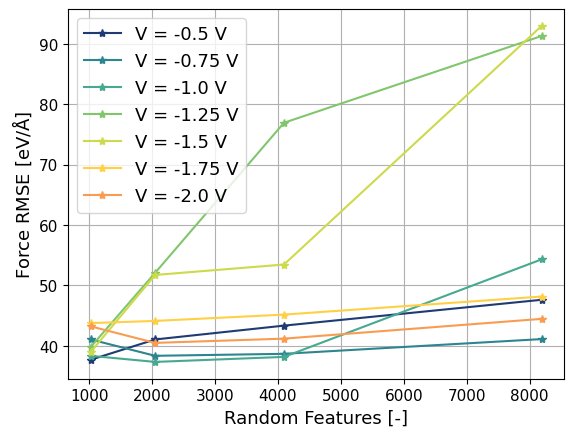

In [11]:
# In this tutorial a minimal hyper-parameter optimization has been performed for sake of simplicity
# => Suggested to perform a more detailed optimization

# Choose a color palette (e.g., 'fessa_r' has 7 distinct colors)
from fessa_color_palette import fessa
# Get the colormap
cmap = plt.get_cmap('fessa')

# Sample colors from the colormap
palette = [cmap(i / len(V_vector_labels)) for i in range(len(V_vector_labels))]

for V,V_numerical_format,color in zip(V_vector_labels,V_vector,palette):
    print(f"Results for target potential {V_numerical_format} V vs SHE:")

    RMSE_force=[]
    for rf in RF_cases:
            
        run_dirs=glob.glob(f"Training/results_multi_potential/case_{V}_RF_{rf}/run_*/")            
            
        # Select the most recent run directory based on DAY_HOUR
        run_dirs_sorted = sorted(run_dirs, key=lambda x: datetime.strptime("20"+"_".join(x.split("_")[-3:-1]), "%Y%m%d_%H%M%S"))
        latest_run_dir = run_dirs_sorted[-1]  # Latest run

        # Path to log.json in the latest run
        log_path = os.path.join(latest_run_dir, "log.json")
        best_path= os.path.join(latest_run_dir, "best.json")
        # We load the full logs for all training runs and the logs for just the best model.
        with open(log_path, "r") as fh:
            all_logs = json.load(fh)
        with open(best_path, "r") as fh:
            best_log = json.load(fh)

        best_lenght_scale = best_log["hyperparameters"]["random_features"]["length_scale"]
        best_l2 = best_log["hyperparameters"]["solver"]["l2_penalty"]
        best_fw = best_log["hyperparameters"]["solver"]["force_weight"]
        print(f"\t{rf} Random Features - Best hyperparameters: ")
        print(f"\t\tLength-scale: {best_lenght_scale:.1f}, L2 penalty: {best_l2:.2e}, Force-weight: {best_fw:.3f}")

        # Extract metrics (e.g., RMSE on forces)

        logs_df = pd.json_normalize(all_logs)  # flattens nested dictionaries and converts to DataFrame
        logs_df.head()
        df_fw = logs_df[  # Fix the other hyperparameters
                (logs_df["hyperparameters.solver.l2_penalty"] == best_l2) & (logs_df["hyperparameters.solver.force_weight"] == best_fw) & (logs_df["hyperparameters.random_features.length_scale"]==best_lenght_scale) 
            ]
        RMSE_force.append(df_fw["metrics.validation.forces_RMSE"].values[0])

    plt.plot(RF_cases,RMSE_force, label=f"V = {V_numerical_format} V",color=color,marker='*')

# Plot accuracy vs RMSE at different applied potential

params = {'mathtext.default': 'regular' } 
plt.rcParams.update(params)
plt.xlabel('Random Features [-]',fontsize=13)
plt.ylabel('Force RMSE [eV/$\AA$]',fontsize=13)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
plt.grid()
plt.legend(fontsize=13)
plt.show()

Choose the random feature values used for the different potential cases

In [12]:
print('The target potentials (V vs SHE) are: ', V_vector)

# The dataset size is very small so the most safe choice is a small number of Random Features
rf_chosen = [1024]*len(V_vector)  # Example choice of RF for each potential
if len(rf_chosen) != len(V_vector):
    raise ValueError("Length of rf_chosen must be equal to the length of V_vector") 
print('The corresponding random features are: ',rf_chosen)

The target potentials (V vs SHE) are:  [-0.5  -0.75 -1.   -1.25 -1.5  -1.75 -2.  ]
The corresponding random features are:  [1024, 1024, 1024, 1024, 1024, 1024, 1024]
